<a href="https://colab.research.google.com/github/biplobsd/predict-future-sales-/blob/main/Predict_Future_Sales_(Alpha_test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

101


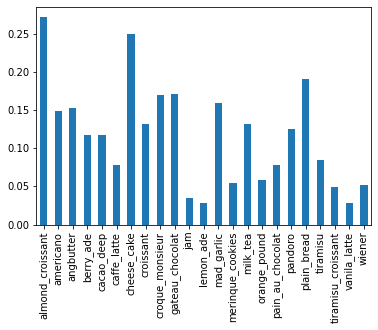

In [51]:
#@title Predict Future Sales
input_date = "2021-01-01" #@param {type:"date"}
product_name = "gateau_chocolat" #@param ['angbutter','plain_bread','jam','americano','croissant','caffe_latte','tiramisu_croissant','cacao_deep','pain_au_chocolat','almond_croissant','croque_monsieur','mad_garlic','milk_tea','gateau_chocolat','pandoro','cheese_cake','lemon_ade','orange_pound','wiener','vanila_latte','berry_ade','tiramisu', 'merinque_cookies']
show_all_with_plot = True #@param {type:"boolean"}
import datetime
import numpy as np
import tensorflow as tf
import pandas as pd
import joblib
import os
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

MODEL = 'data/model.tflite'
SCALER = 'data/scaler.gz'
SCALERIN = 'data/scalerInput.gz'
year, month, day = input_date.split('-')
weekday = datetime.date(day=int(day), month=int(month), year=int(year)).weekday()
INPUT = int(month+day)
os.makedirs('data', exist_ok=True)

if not os.path.exists(MODEL):
  !wget https://github.com/biplobsd/predict-future-sales-/releases/download/v0.3/model.tflite -O $MODEL
  clear_output()

if not os.path.exists(SCALER):
  !wget https://github.com/biplobsd/predict-future-sales-/releases/download/v0.3/scaler.gz -O $SCALER
  clear_output()

if not os.path.exists(SCALERIN):
  !wget https://github.com/biplobsd/predict-future-sales-/releases/download/v0.3/scalerInput.gz -O $SCALERIN
  clear_output()


def lite_model(interpreter, inputs):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], inputs)
  interpreter.invoke()
  output = {}
  labels = interpreter.get_signature_list()['serving_default']['outputs']
  for i,v in enumerate(interpreter.get_output_details()):
    output[labels[i]] = interpreter.get_tensor(v['index'])[0][0]
  return output

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

scaler = joblib.load(SCALER)
scalerInput = joblib.load(SCALERIN)

interpreter = tf.lite.Interpreter(model_path=MODEL)
print(INPUT)
prediction = lite_model(
    interpreter, 
    scalerInput.transform(pd.DataFrame([{'mdd': np.float32(INPUT)}]))
)
pr = pd.DataFrame([prediction])
out = pd.DataFrame(scaler.inverse_transform(pr.values), columns=pr.columns, index=pr.index)
if show_all_with_plot:
  row = out.iloc[0]
  row.plot(kind='bar')
  plt.show()
else:
  print(out[[product_name]])